# 1. Data Loading

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sean's mount
os.chdir('/content/drive/MyDrive/CSCI 657/Project/data')
train_file = 'train_150k'
test_file = 'test_62k'

Mounted at /content/drive


In [ ]:
file = open(f'{train_file}.txt', "r")
train_txt = file.readlines()
print(train_txt)
file.close()

file = open(f'{test_file}.txt', "r")
test_txt = file.readlines()
print(test_txt)
file.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 2. Data Preprocessing

## 2.1 Retrieve and split train set, validation set, and test set

In [ ]:
def text_label_split(txt_file, set_max=None):
    label_lst = []
    text_lst = []

    for i in range(len(txt_file)):
        line = txt_file[i]
        label = line[0]
        text = line[2:-1]
        label_lst.append(label)
        text_lst.append(text)

    return label_lst[:set_max], text_lst[:set_max]

train_size = 8000
test_size = 2000
val_size = train_size + test_size

tr_label, tr_text = text_label_split(train_txt, train_size)
ts_label, ts_text = text_label_split(test_txt, test_size)
val_label, val_text = text_label_split(train_txt, val_size)
val_label, val_text = val_label[train_size:], val_text[train_size:]
corpus_tr_label, corpus_tr_text = text_label_split(train_txt)
corpus_ts_label, corpus_ts_text = text_label_split(test_txt)
corpus_text = corpus_tr_text + corpus_ts_text

print("Total training label: {0}".format(len(tr_label)))
print("Total training text: {0}".format(len(tr_text)))
print("Total testing label: {0}".format(len(ts_label)))
print("Total testing text: {0}".format(len(ts_text)))
print("Total validating label: {0}".format(len(val_label)))
print("Total validating text: {0}".format(len(val_text)))
print("Total testing text for the corpus: {0}".format(len(corpus_text)))

Total training label: 8000
Total training text: 8000
Total testing label: 2000
Total testing text: 2000
Total validating label: 2000
Total validating text: 2000
Total testing text for the corpus: 211983


In [ ]:
print("Sample of training text: {0}".format(tr_text[:10]))
print("Sample of training label: {0}".format(tr_label[:10]))

Sample of training text: ["Starting  back at work today   Looks like it'll be raining for the next couple of days ", 'Sugar levels dropping... munchies setting in. Luckily I have a black chocolate Toblerone in the fridge ', '@karineb22 yeah!!! have a great summer break! ', 'hannah montana was very good.  now going to read twilight. ', '@Mayra326 aww, have fun!  I just had my 3D last week!', 'Worried about my cat. Took him to the vet and his blood work etc was all normal but hes still not eatting ', 'Dancing on cloud nine with my significant other.... i got accepted into Nursing School at Del Mar College for this fall ', '@asherroth omg pls take one for me all i have is bacardi and dr pepper ', "How did i get stuck watchin over everything Smh Damn n im hungry  didn't have ne breakfast", '@sunday67 : only 5 days remaining ']
Sample of training label: ['0', '1', '1', '1', '1', '0', '1', '0', '0', '0']


In [ ]:
print("Number negatives of training text: {0}".format(tr_label.count('0')))
print("Number positives of training text: {0}".format(tr_label.count('1')))
print("Number negatives of testing text: {0}".format(ts_label.count('0')))
print("Number positives of testing text: {0}".format(ts_label.count('1')))
print("Number negatives of validating text: {0}".format(val_label.count('0')))
print("Number positives of validating text: {0}".format(val_label.count('1')))

Number negatives of training text: 3992
Number positives of training text: 4008
Number negatives of testing text: 1010
Number positives of testing text: 990
Number negatives of validating text: 998
Number positives of validating text: 1002


## 2.2 Tidying text and tokenization

Utilize regular expressions to eliminate all punctuation marks from the dataset due to the significant presence of such symbols. Punctuation is often regarded as noise in textual data and is undesirable for our model. Our objective is to minimize textual noise, enhancing the performance of our models. Nevertheless, there are instances, such as in sentiment analysis, where retaining punctuation could be beneficial. Since we are also employing word embedding models, punctuation removal is incorporated into our preprocessing procedures.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

def tidy_text_re(x):
    x = re.sub(r'[^\w\s]', '',x)
    x = re.sub(r'\([^)]*\)', '', x).lower()
    return x

tr_tidy = [tidy_text_re(s) for s in tr_text]
val_tidy  = [tidy_text_re(s) for s in val_text]
ts_tidy  = [tidy_text_re(s) for s in ts_text]
corpus_tidy  = [tidy_text_re(s) for s in corpus_text]

tr_tokens = [word_tokenize(s) for s in tr_tidy]
val_tokens = [word_tokenize(s) for s in val_tidy]
ts_tokens = [word_tokenize(s) for s in ts_tidy]
corpus = [word_tokenize(s) for s in corpus_tidy]

print("Sample of training text after tidying text: {0}".format(tr_tokens[:10]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Sample of training text after tidying text: [['starting', 'back', 'at', 'work', 'today', 'looks', 'like', 'itll', 'be', 'raining', 'for', 'the', 'next', 'couple', 'of', 'days'], ['sugar', 'levels', 'dropping', 'munchies', 'setting', 'in', 'luckily', 'i', 'have', 'a', 'black', 'chocolate', 'toblerone', 'in', 'the', 'fridge'], ['karineb22', 'yeah', 'have', 'a', 'great', 'summer', 'break'], ['hannah', 'montana', 'was', 'very', 'good', 'now', 'going', 'to', 'read', 'twilight'], ['mayra326', 'aww', 'have', 'fun', 'i', 'just', 'had', 'my', '3d', 'last', 'week'], ['worried', 'about', 'my', 'cat', 'took', 'him', 'to', 'the', 'vet', 'and', 'his', 'blood', 'work', 'etc', 'was', 'all', 'normal', 'but', 'hes', 'still', 'not', 'eatting'], ['dancing', 'on', 'cloud', 'nine', 'with', 'my', 'significant', 'other', 'i', 'got', 'accepted', 'into', 'nursing', 'school', 'at', 'del', 'mar', 'college', 'for', 'this', 'fall'], ['asherroth', 'omg', 'pls', 'take', 'one', 'for', 'me', 'all', 'i', 'have', 'is', '

In [ ]:
print("Sample of corpus: {0}".format(corpus[:10]))


def flatten(matrix):
    flat_list = []

    for row in matrix:
        flat_list.extend(row)

    return flat_list


corpus_ = flatten(corpus)
wordbank = list(set(corpus_))
print("Sample of wordbank: {0}".format(wordbank[:10]))
print("Size of wordbank: {0}".format(len(wordbank)))

Sample of corpus: [['starting', 'back', 'at', 'work', 'today', 'looks', 'like', 'itll', 'be', 'raining', 'for', 'the', 'next', 'couple', 'of', 'days'], ['sugar', 'levels', 'dropping', 'munchies', 'setting', 'in', 'luckily', 'i', 'have', 'a', 'black', 'chocolate', 'toblerone', 'in', 'the', 'fridge'], ['karineb22', 'yeah', 'have', 'a', 'great', 'summer', 'break'], ['hannah', 'montana', 'was', 'very', 'good', 'now', 'going', 'to', 'read', 'twilight'], ['mayra326', 'aww', 'have', 'fun', 'i', 'just', 'had', 'my', '3d', 'last', 'week'], ['worried', 'about', 'my', 'cat', 'took', 'him', 'to', 'the', 'vet', 'and', 'his', 'blood', 'work', 'etc', 'was', 'all', 'normal', 'but', 'hes', 'still', 'not', 'eatting'], ['dancing', 'on', 'cloud', 'nine', 'with', 'my', 'significant', 'other', 'i', 'got', 'accepted', 'into', 'nursing', 'school', 'at', 'del', 'mar', 'college', 'for', 'this', 'fall'], ['asherroth', 'omg', 'pls', 'take', 'one', 'for', 'me', 'all', 'i', 'have', 'is', 'bacardi', 'and', 'dr', 'pe

## 2.3 Word embedding

In [ ]:
from gensim.models import Word2Vec
wv_skipGram_model = Word2Vec(sentences=corpus, vector_size=399, window=6, min_count=6, workers=4, sg=1)
# ~2m10s

In [ ]:
wv_skipGram_model.wv.most_similar('omg', topn=10)

[('omfg', 0.7049331068992615),
 ('omggg', 0.6446673274040222),
 ('omj', 0.6319937705993652),
 ('omgg', 0.6279132962226868),
 ('omgosh', 0.6246828436851501),
 ('ahhh', 0.6153869032859802),
 ('rofl', 0.6065226197242737),
 ('omgggg', 0.606407880783081),
 ('ahhhhh', 0.6051003336906433),
 ('friggin', 0.6044378876686096)]

In [ ]:
import torch
wv_skipGram_path = 'wv_skipGram_model.ckpt'
torch.save(wv_skipGram_model, wv_skipGram_path)

In [ ]:
import torch

wv_skipGram_path = 'wv_skipGram_model.ckpt'
wv_skipGram_model = torch.load(wv_skipGram_path, map_location=torch.device('cpu'))

## 2.4 Lexicon embedding

In [ ]:
# ==============================
# DO NOT RUN!!!!!!!!!!

nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

# construct a word dictionary for each word based on lexicon embedding
# not_exist(0), negative(1), positive(2)
word_dict = {}
for word in wordbank:
    if word in opinion_lexicon.negative():
        word_dict[word] = 1
    elif word in opinion_lexicon.positive():
        word_dict[word] = 2
    else:
        word_dict[word] = 0

print(word_dict)

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import pickle

# save the constructed dict
with open('word_dict.pkl', 'wb') as f:
    pickle.dump(word_dict, f)

## 2.5 Sequence length selection

In [ ]:
import pickle

# load the constructed dict
with open('word_dict.pkl', 'rb') as f:
    word_dict = pickle.load(f)

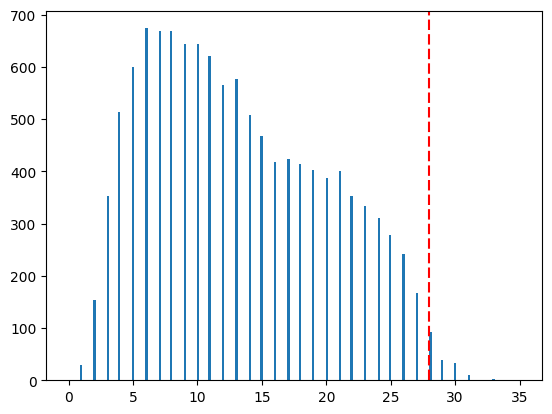

In [ ]:
text_len_list = []
corpus_model = tr_tokens + ts_tokens + val_tokens

for text in corpus_model:
    text_len_list.append(len(text))

import matplotlib.pyplot as plt
max_len = 28 # set the max length as 28 since it covers most of the text lengths
plt.hist(text_len_list, 200, range=(0,35))
plt.axvline(x=max_len, color="red", dashes=[5,2])
plt.show()

## 2.6 Naive concatenation and sequence truncation

In [ ]:
# map each word to its embeded vector
text_transform = lambda x: [np.array(list(wv_skipGram_model.wv[token]) + [word_dict[token]]) if token in wv_skipGram_model.wv else [0]*400 for token in x]
# tidy the label
label_transform = lambda x: 1 if x == '1' else 0

def text_truncated(input_set, max_len=28):
    input_df = pd.DataFrame(input_set).T
    input_df = input_df[:max_len].T
    input_set_trunc = [[y for y in x if pd.notna(y)] for x in input_df.values.tolist()]
    return input_set_trunc


def pad(trunc_input, max_len=28):
    tmp = pd.DataFrame(np.array(trunc_input))
    tmp = tmp[0].apply(lambda x: np.array(text_transform(x)))
    res = []
    for lst in tmp:
        if lst.shape[0] < max_len:
            missing = max_len - lst.shape[0]
            filling = [0] * 400 * missing
            filling = np.array(filling).reshape(missing, 400)
            padded = np.concatenate((lst, filling), axis=0)
        else:
            padded = lst
        res.append(padded)
    return np.array(res)


tr_trunc = text_truncated(tr_tokens)
train_embeddings = pad(tr_trunc)

ts_trunc = text_truncated(ts_tokens)
test_embeddings = pad(ts_trunc)

val_trunc = text_truncated(val_tokens)
val_embeddings = pad(val_trunc)


<ipython-input-12-0177dd095d07>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = pd.DataFrame(np.array(trunc_input))


# 3. Sequential Models

## 3.1 Bi-LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set up the parameters
seq_length = 28
n_input = 400
n_class = np.unique(tr_label).shape[0]
n_hidden = 32
batch_size = 256
total_epoch = 20
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Bi_LSTM(nn.Module):
    def __init__(self):
        super(Bi_LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first=True, num_layers=2, dropout=0.5, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = x.to(torch.float32)
        lstm_out, (h_n, c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:], h_n[1,:,:]), 1)

        output = self.linear(hidden_out)

        return output


In [ ]:
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch
import time
from datetime import timedelta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
Bi_LSTM_model = Bi_LSTM().to(device)
optimizer = optim.Adam(Bi_LSTM_model.parameters(), lr=learning_rate, weight_decay=0)

save_path_lstm = 'BiLSTM.ckpt'
train_acc_lst = []
val_acc_lst = []
loss_lst = []

start = time.time()
for epoch in range(total_epoch):
    # Training loop
    train_loss = 0
    for ind in range(0, train_embeddings.shape[0], batch_size):
        input_batch = train_embeddings[ind:min(ind + batch_size, train_embeddings.shape[0])]
        target_batch = tr_label[ind:min(ind + batch_size, train_embeddings.shape[0])]
        target_batch = [eval(i) for i in target_batch]
        target_batch = np.array(target_batch)
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)
        Bi_LSTM_model.train()
        optimizer.zero_grad()
        outputs = Bi_LSTM_model(input_batch_torch)
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs, 1)
        train_acc = accuracy_score(predicted.cpu().numpy(), target_batch_torch.cpu().numpy())
        train_loss += loss.item()

    # Validation loop
    val_loss = 0
    val_preds = []
    with torch.no_grad():
        for ind in range(0, val_embeddings.shape[0], batch_size):
            val_input_batch = val_embeddings[ind:min(ind + batch_size, val_embeddings.shape[0])]
            val_target_batch = val_label[ind:min(ind + batch_size, val_embeddings.shape[0])]
            val_target_batch = [eval(i) for i in val_target_batch]
            val_target_batch = np.array(val_target_batch)
            val_input_batch_torch = torch.from_numpy(val_input_batch).float().to(device)
            val_target_batch_torch = torch.from_numpy(val_target_batch).view(-1).to(device)
            Bi_LSTM_model.eval()
            val_outputs = Bi_LSTM_model(val_input_batch_torch)
            val_loss += criterion(val_outputs, val_target_batch_torch).item()
            val_preds = torch.argmax(val_outputs, 1).cpu().numpy()

    val_acc = accuracy_score(val_preds, val_target_batch)
    avg_train_loss = train_loss / len(train_embeddings)
    avg_val_loss = val_loss / len(val_embeddings)
    train_acc_lst.append(train_acc)
    val_acc_lst.append(val_acc)
    loss_lst.append(avg_train_loss)

    print('Epoch: %d, Train Loss: %.5f, Train Acc: %.5f, Val Loss: %.5f, Val Acc: %.5f' % (
        epoch + 1, avg_train_loss, train_acc, avg_val_loss, val_acc))

end = time.time()
time_elapsed = end - start
print('Finished Training, time cost: {}'.format(timedelta(seconds=time_elapsed)))
torch.save(Bi_LSTM_model, save_path_lstm)


Epoch: 1, Train Loss: 0.00269, Train Acc: 0.68750, Val Loss: 0.00249, Val Acc: 0.69712
Epoch: 2, Train Loss: 0.00229, Train Acc: 0.75000, Val Loss: 0.00222, Val Acc: 0.75481
Epoch: 3, Train Loss: 0.00213, Train Acc: 0.81250, Val Loss: 0.00216, Val Acc: 0.74519
Epoch: 4, Train Loss: 0.00205, Train Acc: 0.82812, Val Loss: 0.00212, Val Acc: 0.75962
Epoch: 5, Train Loss: 0.00200, Train Acc: 0.84375, Val Loss: 0.00210, Val Acc: 0.74519
Epoch: 6, Train Loss: 0.00196, Train Acc: 0.84375, Val Loss: 0.00208, Val Acc: 0.75000
Epoch: 7, Train Loss: 0.00192, Train Acc: 0.84375, Val Loss: 0.00207, Val Acc: 0.75962
Epoch: 8, Train Loss: 0.00188, Train Acc: 0.90625, Val Loss: 0.00206, Val Acc: 0.75481
Epoch: 9, Train Loss: 0.00184, Train Acc: 0.90625, Val Loss: 0.00207, Val Acc: 0.75962
Epoch: 10, Train Loss: 0.00179, Train Acc: 0.92188, Val Loss: 0.00208, Val Acc: 0.75481
Epoch: 11, Train Loss: 0.00174, Train Acc: 0.92188, Val Loss: 0.00209, Val Acc: 0.76442
Epoch: 12, Train Loss: 0.00171, Train Acc

In [ ]:
save_path_lstm = 'BiLSTM.ckpt'
torch.save(Bi_LSTM_model, save_path_lstm)

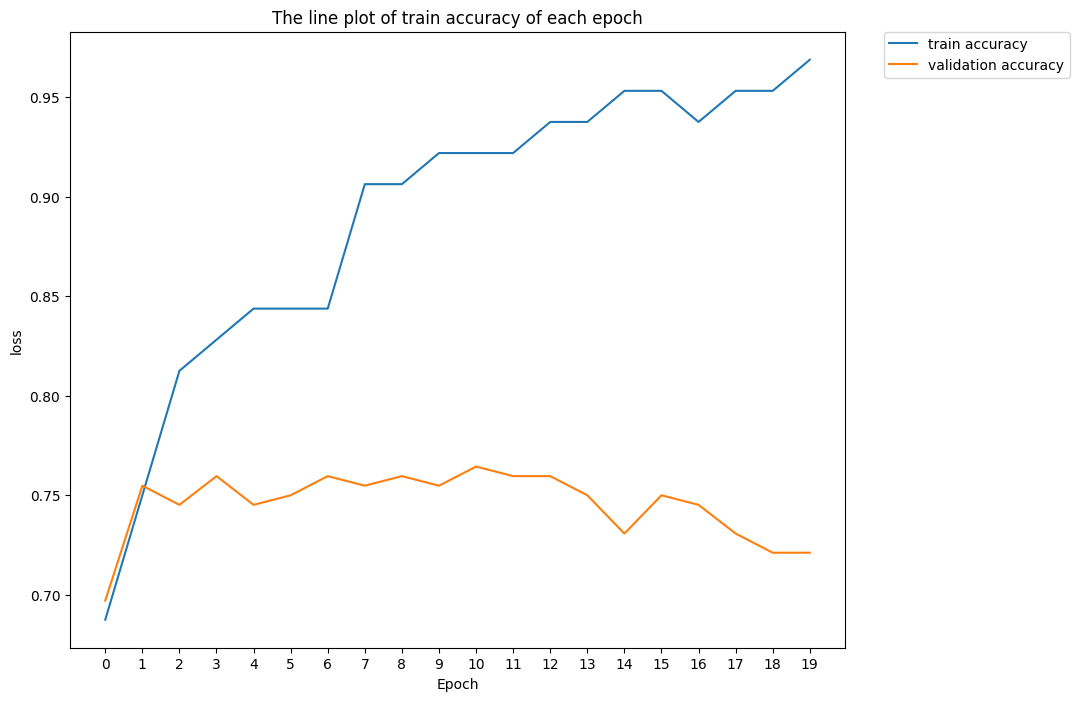

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(total_epoch), train_acc_lst, label = 'train accuracy')
plt.plot(range(total_epoch), val_acc_lst, label = 'validation accuracy')
xticks = range(total_epoch)
x = np.array(range(total_epoch))
plt.xticks(x, xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('The line plot of train accuracy of each epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

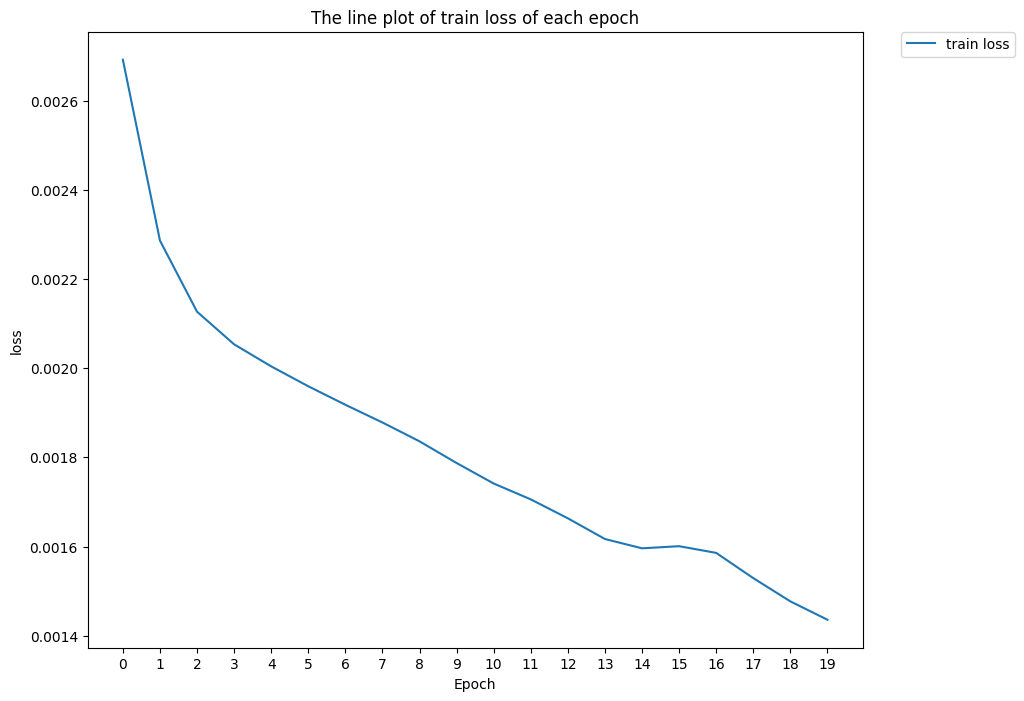

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(total_epoch), loss_lst, label = 'train loss')
xticks = range(total_epoch)
x = np.array(range(total_epoch))
plt.xticks(x, xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('The line plot of train loss of each epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

save_path_lstm = 'BiLSTM.ckpt'
Bi_LSTM_model = torch.load(save_path_lstm, map_location=torch.device('cpu'))
Bi_LSTM_model.eval()
outputs = Bi_LSTM_model(torch.from_numpy(test_embeddings).float().to(device))
Bi_LSTM_predicted = torch.argmax(outputs, 1)
ts_label_ = pd.DataFrame(ts_label)
ts_true = np.array(ts_label_[0].apply(lambda x: label_transform(x)))

print('Classification report of the Bi-LSTM model on the test set')
print(classification_report(ts_true, Bi_LSTM_predicted.cpu().numpy(),digits=4))

Classification report of the Bi-LSTM model on the test set
              precision    recall  f1-score   support

           0     0.7666    0.7317    0.7487      1010
           1     0.7384    0.7727    0.7552       990

    accuracy                         0.7520      2000
   macro avg     0.7525    0.7522    0.7520      2000
weighted avg     0.7526    0.7520    0.7519      2000



## 3.2 Bi-RNN Model

In [ ]:
# Set up the parameters
seq_length = 28
n_input = 400
n_class = np.unique(tr_label).shape[0]
n_hidden = 32
batch_size = 256
total_epoch = 20
learning_rate = 1e-3

class Bi_RNN(nn.Module):
    def __init__(self):
        super(Bi_RNN, self).__init__()

        self.rnn = nn.RNN(n_input, n_hidden, batch_first=True, num_layers=1, dropout=0.5, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = x.to(torch.float32)
        rnn_out, h_n = self.rnn(x)
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        output = self.linear(hidden_out)
        return output

In [ ]:
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
birnn_model = Bi_RNN().to(device)
optimizer = optim.Adam(birnn_model.parameters(), lr=learning_rate, weight_decay=0)


save_path_rnn = 'BiRNN.ckpt'
train_acc_lst = []
val_acc_lst = []
loss_lst = []

start = time.time()
for epoch in range(total_epoch):
    # Training loop
    train_loss = 0
    for ind in range(0, train_embeddings.shape[0], batch_size):
        input_batch = train_embeddings[ind:min(ind + batch_size, train_embeddings.shape[0])]
        target_batch = tr_label[ind:min(ind + batch_size, train_embeddings.shape[0])]
        target_batch = [eval(i) for i in target_batch]
        target_batch = np.array(target_batch)
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)
        birnn_model.train()
        optimizer.zero_grad()
        outputs = birnn_model(input_batch_torch)
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs, 1)
        train_acc = accuracy_score(predicted.cpu().numpy(), target_batch_torch.cpu().numpy())
        train_loss += loss.item()

    # Validation loop
    val_loss = 0
    val_preds = []
    with torch.no_grad():
        for ind in range(0, val_embeddings.shape[0], batch_size):
            val_input_batch = val_embeddings[ind:min(ind + batch_size, val_embeddings.shape[0])]
            val_target_batch = val_label[ind:min(ind + batch_size, val_embeddings.shape[0])]
            val_target_batch = [eval(i) for i in val_target_batch]
            val_target_batch = np.array(val_target_batch)
            val_input_batch_torch = torch.from_numpy(val_input_batch).float().to(device)
            val_target_batch_torch = torch.from_numpy(val_target_batch).view(-1).to(device)
            birnn_model.eval()
            val_outputs = birnn_model(val_input_batch_torch)
            val_loss += criterion(val_outputs, val_target_batch_torch).item()
            val_preds = torch.argmax(val_outputs, 1).cpu().numpy()

    val_acc = accuracy_score(val_preds, val_target_batch)
    avg_train_loss = train_loss / len(train_embeddings)
    avg_val_loss = val_loss / len(val_embeddings)
    train_acc_lst.append(train_acc)
    val_acc_lst.append(val_acc)
    loss_lst.append(avg_train_loss)

    print('Epoch: %d, Train Loss: %.5f, Train Acc: %.5f, Val Loss: %.5f, Val Acc: %.5f' % (
        epoch + 1, avg_train_loss, train_acc, avg_val_loss, val_acc))

end = time.time()
time_elapsed = end - start
print('Finished Training, time cost: {}'.format(timedelta(seconds=time_elapsed)))
torch.save(birnn_model, save_path_rnn)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1, Train Loss: 0.00267, Train Acc: 0.65625, Val Loss: 0.00255, Val Acc: 0.62019
Epoch: 2, Train Loss: 0.00235, Train Acc: 0.76562, Val Loss: 0.00230, Val Acc: 0.72115
Epoch: 3, Train Loss: 0.00215, Train Acc: 0.81250, Val Loss: 0.00219, Val Acc: 0.78365
Epoch: 4, Train Loss: 0.00213, Train Acc: 0.85938, Val Loss: 0.00220, Val Acc: 0.74519
Epoch: 5, Train Loss: 0.00206, Train Acc: 0.84375, Val Loss: 0.00220, Val Acc: 0.74519
Epoch: 6, Train Loss: 0.00201, Train Acc: 0.87500, Val Loss: 0.00217, Val Acc: 0.76923
Epoch: 7, Train Loss: 0.00196, Train Acc: 0.89062, Val Loss: 0.00217, Val Acc: 0.75481
Epoch: 8, Train Loss: 0.00191, Train Acc: 0.90625, Val Loss: 0.00218, Val Acc: 0.77885
Epoch: 9, Train Loss: 0.00187, Train Acc: 0.92188, Val Loss: 0.00219, Val Acc: 0.77404
Epoch: 10, Train Loss: 0.00181, Train Acc: 0.92188, Val Loss: 0.00221, Val Acc: 0.78846
Epoch: 11, Train Loss: 0.00177, Train Acc: 0.92188, Val Loss: 0.00223, Val Acc: 0.79327
Epoch: 12, Train Loss: 0.00175, Train Acc

In [ ]:
save_path_rnn = 'BiRNN.ckpt'
torch.save(birnn_model, save_path_rnn)

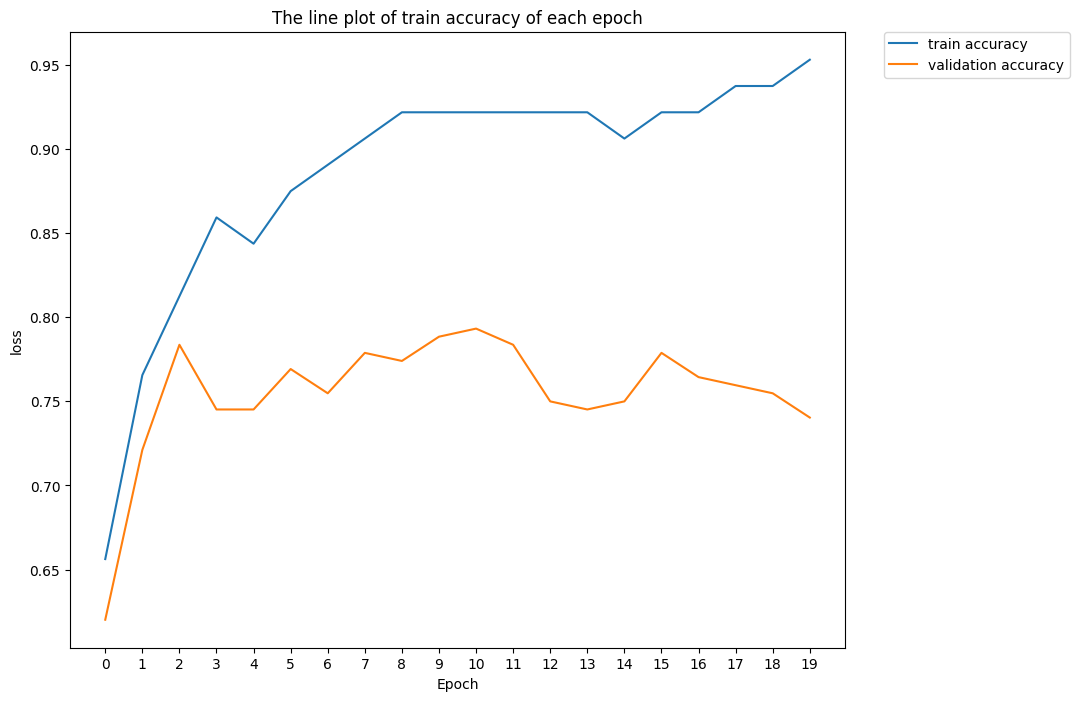

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(total_epoch), train_acc_lst, label = 'train accuracy')
plt.plot(range(total_epoch), val_acc_lst, label = 'validation accuracy')
xticks = range(total_epoch)
x = np.array(range(total_epoch))
plt.xticks(x, xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('The line plot of train accuracy of each epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

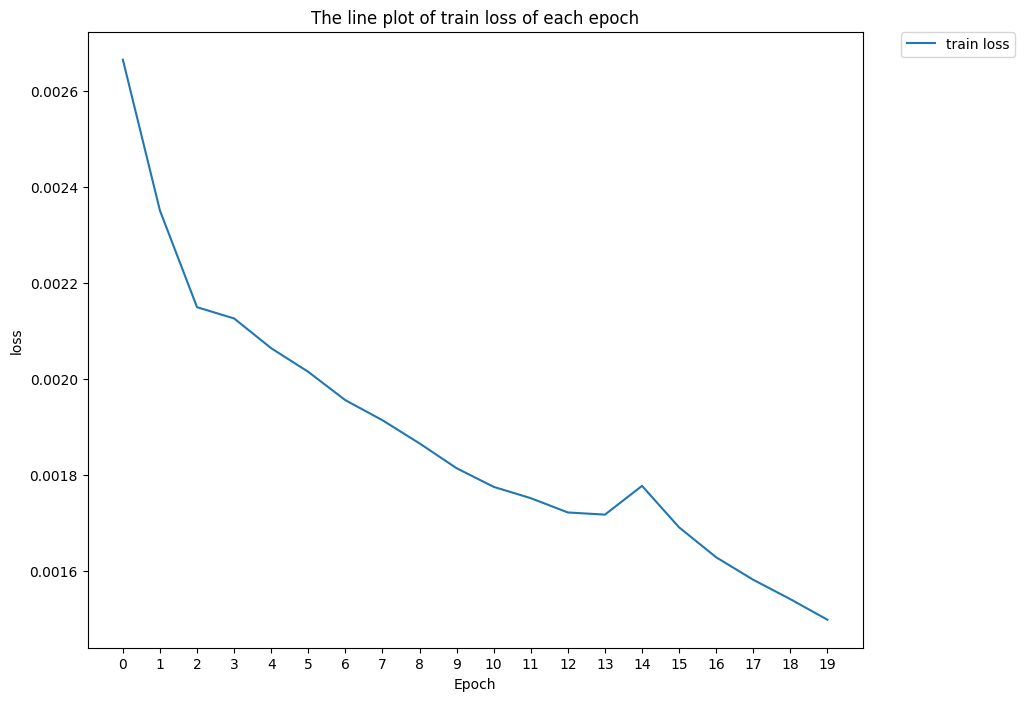

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(total_epoch), loss_lst, label = 'train loss')
xticks = range(total_epoch)
x = np.array(range(total_epoch))
plt.xticks(x, xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('The line plot of train loss of each epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc


save_path_rnn = 'BiRNN.ckpt'
Bi_RNN_model = torch.load(save_path_rnn, map_location=torch.device('cpu'))
Bi_RNN_model.eval()
outputs = Bi_RNN_model(torch.from_numpy(test_embeddings).float().to(device))
Bi_RNN_predicted = torch.argmax(outputs, 1)
ts_label_ = pd.DataFrame(ts_label)
ts_true = np.array(ts_label_[0].apply(lambda x: label_transform(x)))

print('Classification report of the Bi-RNN model on the test set')
print(classification_report(ts_true, Bi_RNN_predicted.cpu().numpy(),digits=4))

Classification report of the Bi-RNN model on the test set
              precision    recall  f1-score   support

           0     0.7150    0.7574    0.7356      1010
           1     0.7366    0.6919    0.7135       990

    accuracy                         0.7250      2000
   macro avg     0.7258    0.7247    0.7246      2000
weighted avg     0.7256    0.7250    0.7247      2000



# 4. Demonstration

## 4.1 Helper functions

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sean's mount
os.chdir('/content/drive/MyDrive/CSCI 657/Project/data')
train_file = 'train_150k'
test_file = 'test_62k'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
import torch

wv_skipGram_path = 'wv_skipGram_model.ckpt'
wv_skipGram_model = torch.load(wv_skipGram_path, map_location=torch.device('cpu'))
import pickle

# load the constructed dict
with open('word_dict.pkl', 'rb') as f:
    word_dict = pickle.load(f)

def tidy_text_re(x):
    x = re.sub(r'[^\w\s]', '',x)
    x = re.sub(r'\([^)]*\)', '', x).lower()
    return x

text_transform = lambda x: [np.array(list(wv_skipGram_model.wv[token]) + [word_dict[token]]) if token in wv_skipGram_model.wv else [0]*400 for token in x]

def text_transform_demo(seq_token):
  res = []
  for token in seq_token:
      res.append(np.hstack(text_transform(token)))
  return res

def text_truncated(input_set, max_len=28):
    input_df = pd.DataFrame(input_set).T
    input_df = input_df[:max_len].T
    input_set_trunc = [[y for y in x if pd.notna(y)] for x in input_df.values.tolist()]
    return input_set_trunc


def pad_demo(seq, max_len=28):
    tmp = pd.DataFrame(np.array(seq))
    tmp = tmp = text_transform_demo(seq)
    missing = max_len - len(tmp)
    filling = [0] * 400 * missing
    filling = np.array(filling).reshape(missing, 400)
    padded = np.concatenate((tmp, filling), axis=0)
    return padded

def demo(demo_seq, model):
    demo_tidy = tidy_text_re(demo_seq)
    demo_tokenized = word_tokenize(demo_tidy)
    demo_trunc = text_truncated(demo_tokenized)
    demo_embeddings = pad_demo(demo_trunc)
    demo_embeddings = demo_embeddings.reshape(1, 28, 400)
    save_path_lstm = 'BiLSTM.ckpt'
    save_path_rnn = 'BiRNN.ckpt'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model.lower() == 'bilstm':
        Bi_LSTM_model = torch.load(save_path_lstm, map_location=torch.device('cpu'))
        Bi_LSTM_model.eval()
        outputs = Bi_LSTM_model(torch.from_numpy(demo_embeddings).float().to(device))
        predicted = torch.argmax(outputs, 1)
    elif model.lower() == 'birnn':
        Bi_RNN_model = torch.load(save_path_rnn, map_location=torch.device('cpu'))
        Bi_RNN_model.eval()
        outputs = Bi_RNN_model(torch.from_numpy(demo_embeddings).float().to(device))
        predicted = torch.argmax(outputs, 1)
    else:
        raise NotImplementedError("Model Not Implemented")
    if predicted == 1:
        result = 'This is a positive thread'
    elif predicted == 0:
        result = 'This is a negative thread'
    return result

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set up the parameters
seq_length = 28
n_input = 400
n_class = 2
n_hidden = 32
batch_size = 256
total_epoch = 15
learning_rate = 1e-3

class Bi_LSTM(nn.Module):
    def __init__(self):
        super(Bi_LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first=True, num_layers=2, dropout=0.5, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = x.to(torch.float32)
        lstm_out, (h_n, c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:], h_n[1,:,:]), 1)

        output = self.linear(hidden_out)

        return output


In [ ]:
# Set up the parameters
seq_length = 28
n_input = 400
n_class = 2
n_hidden = 32
batch_size = 256
total_epoch = 20
learning_rate = 1e-3

class Bi_RNN(nn.Module):
    def __init__(self):
        super(Bi_RNN, self).__init__()

        self.rnn = nn.RNN(n_input, n_hidden, batch_first=True, num_layers=1, dropout=0.5, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = x.to(torch.float32)
        rnn_out, h_n = self.rnn(x)
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        output = self.linear(hidden_out)
        return output

## 4.2 Demo

In [ ]:
# run section 4.1 first

demo_seq = "@seandulegit: today i went to Keshi's concert with my bestie!!!"
print(demo_seq)
print(demo(demo_seq, 'BiRNN'))
print(demo(demo_seq, 'Bilstm'))
print("=========================")
demo_seq = "@seandulegit: today i went to Keshi's concert!!!"
print(demo_seq)
print(demo(demo_seq, 'BiRNN'))
print(demo(demo_seq, 'Bilstm'))
print("=========================")
demo_seq = "@csyxx: dammmn my lil bunny (YuanYuan) was way too sick last night..."
print(demo_seq)
print(demo(demo_seq, 'BiRNN'))
print(demo(demo_seq, 'Bilstm'))

@seandulegit: today i went to Keshi's concert with my bestie!!!
This is a positive thread
This is a positive thread
@seandulegit: today i went to Keshi's concert!!!
This is a negative thread
This is a positive thread
@csyxx: dammmn my lil bunny (YuanYuan) was way too sick last night...
This is a negative thread
This is a negative thread
